# Outlier X Gridsearch test

This is a test for using isolationforest and the subset by iqr function with gridsearch to optimize finding outliers.

Expected outcome: We can use gridsearch to find the correct IQR to cut by or to use isolationforest to make each column's trimming fine-tuned without manually going through it.

Real Outcome: The results were:
1. Isolationforest gave *worse* results than simply running on a raw dataset
   1. Sometimes considered the whole column as an outlier
   2. Sometimes considered anything >1 an outlier (when it should really be 0 to 100 for example, like attendence percent)
   3. Was effectively impossible to hyper-tune
2. Subset by IQR with gridsearch basically just resulted in it telling you to use top and bottom whisker values of `0` AKA: "dont use IQR Subset".
   1. This also had issues where you can't debug it well, it could be that it just didnt work?
   2. Its unfeasible to run Gridsearch for all columns due to how the runtime scales.
https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as skm
from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from pycaret.classification import *
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
# from pandas_profiling import ProfileReport
from sklearn.decomposition import PCA
from sklearn.ensemble import (ExtraTreesClassifier, IsolationForest,
                              RandomForestClassifier)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, make_scorer, mean_absolute_error, matthews_corrcoef
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, LabelEncoder,
                                   MinMaxScaler, OneHotEncoder, OrdinalEncoder,
                                   StandardScaler)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from shared_utilities import helpers

# from sklearn.pipeline import Pipeline

In [6]:
CLUSTER = "prod-app"
DATABASE = "stlrcanucks"
LKUPCLIENTID = "7"
SCORING_YEAR = 2022
PRODUCT_MAPPING = {'Mini Pack': 0, 'Quarter': 1, 'Half Season': 2, 'Full Season': 3}
PRODUCT_CURRENT_MAPPING = {'Individual': 0, 'Group': 1, 'Mini Pack': 2, 'Quarter': 3, 'Half Season': 4, 'Full Season': 5}

rs = {'random_state': 42}

In [7]:
dataset = helpers.get_product_propensity_dataset(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID,
    scoring_year=SCORING_YEAR,
    type_flag=0
)

dataset.shape

Authorized as AROASQ4JELIXYLYV6P4UV:pmorrison@stellaralgo.com


(699116, 27)

In [8]:
df = dataset.copy()

In [9]:
features = [
    "atp_last",
    "attended_last",
    "distance",
    "events_last",
    "spend_current",
    "sends",
    "tenure",
    "opens",
    "product",
    # "product_current",
    "volume_current"
]

df = df[features]

In [10]:
product_plans = [
   "Full Season",
   "Half Season",
   "Quarter",
   "Mini Pack"
]

In [11]:
df = df[df["product"].isin(product_plans)].reset_index(drop=True)
df.shape

(15915, 10)

In [12]:
df = df.replace("None", np.nan)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.fillna(value=np.nan)
df = df.fillna(method="ffill")
df = df.dropna()

In [13]:
X = df.drop("product", axis=1)
df["product_encoded"] = LabelEncoder().fit_transform(df["product"])
y = df["product_encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                random_state=1121218)

In [14]:
def print_scores(y_test, predictions):
    print(f"MAE: {mean_absolute_error(y_test, predictions)}")
    print(f"F1: {f1_score(y_test, predictions, average=None)}")
    print(f"F1: {f1_score(y_test, predictions, average='weighted')}")
    print(f"Accuracy: {accuracy_score(y_test, predictions)}")
    print(f"MCC: {matthews_corrcoef(y_test, predictions)}")

In [15]:
# Baseline Model test

rf_test = RandomForestClassifier()


df_test = df.copy()
df_test = df_test.dropna()

X = df_test.drop(["product"], axis=1)
X.drop("product_encoded", inplace=True, axis=1)
df_test["product_encoded"] = LabelEncoder().fit_transform(df_test["product"])
y = df_test["product_encoded"]

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y, test_size=.3, 
                                                random_state=1121218)

rf_test.fit(X_train_t, y_train_t)
score = rf_test.score(X_test_t, y_test_t)
print(f"Accuracy: {score}")
pred = rf_test.predict(X_test_t)
print_scores(pred, y_test_t)

Accuracy: 0.8661780104712042
MAE: 0.23958115183246073
F1: [0.9462966  0.62896825 0.33802817 0.80535714]
F1: 0.8709407053734032
Accuracy: 0.8661780104712042
MCC: 0.7465714789340184


In [16]:
iso_forest = IsolationForest(**rs)
iso_forest_params = {
    'n_estimators': np.arange(50, 250, 50),
    'contamination': [0.1, 0.2, 0.3, 0.4, 0.5, 'auto'],
    'max_features': [0.1, 0.5, 1.0]
}

In [17]:
test_df = X_train_t[["distance"]]
X = test_df[["distance"]]
clf = iso_forest.fit(X)
test_df["anomaly"] = clf.predict(X)

In [18]:
test_df.head()

,distance,anomaly
15655,6.87,1
15222,16.51,1
13051,3.48,1
4143,3.07,1
5563,256.79,-1


<AxesSubplot:xlabel='distance', ylabel='Count'>

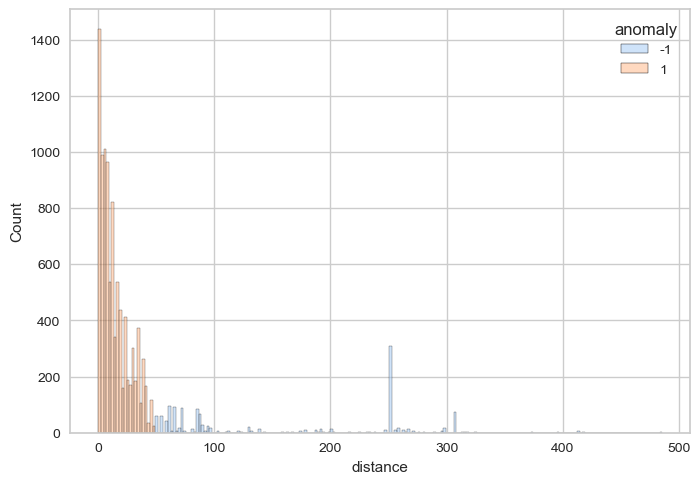

In [19]:
sns.histplot(test_df[test_df["distance"]<500], x="distance", hue="anomaly", palette="pastel")

<AxesSubplot:xlabel='distance', ylabel='Count'>

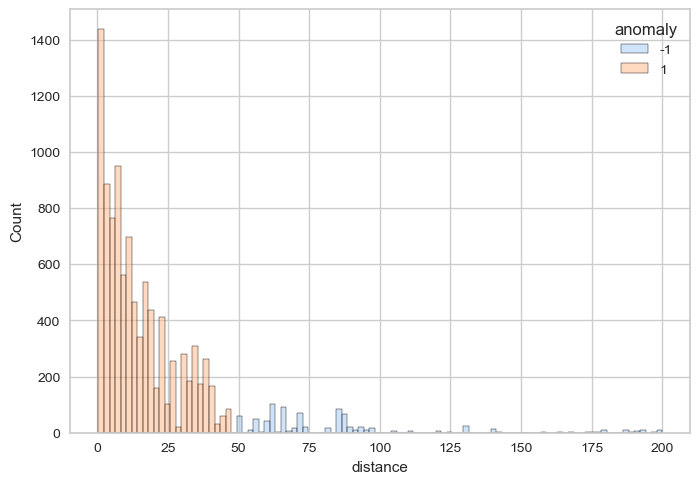

In [20]:
sns.histplot(test_df[test_df["distance"]<200], x="distance", hue="anomaly", palette="pastel")

<AxesSubplot:xlabel='distance', ylabel='Count'>

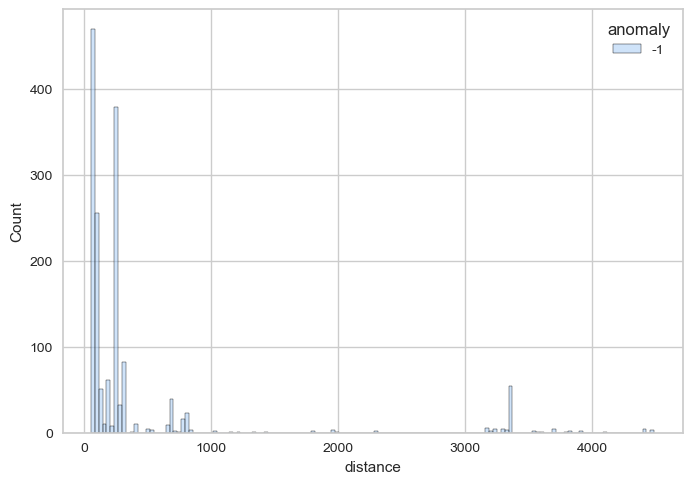

In [21]:
sns.histplot(test_df[test_df["anomaly"]==-1], x="distance", hue="anomaly", palette="pastel")

<AxesSubplot:xlabel='distance', ylabel='Count'>

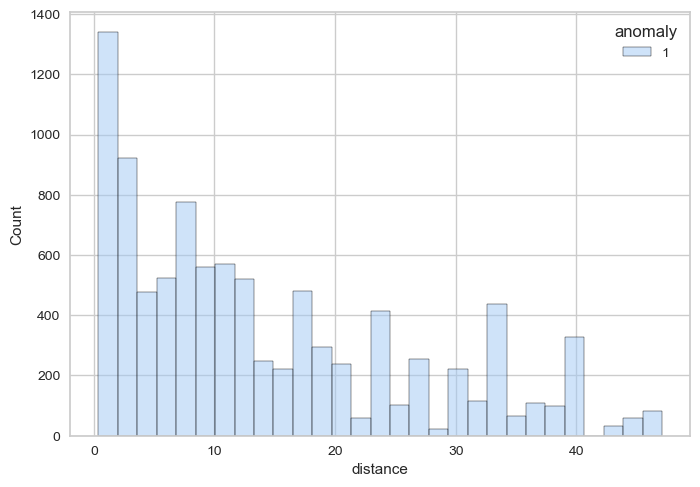

In [22]:
sns.histplot(test_df[test_df["anomaly"]==1], x="distance", hue="anomaly", palette="pastel")

<AxesSubplot:xlabel='distance', ylabel='anomaly'>

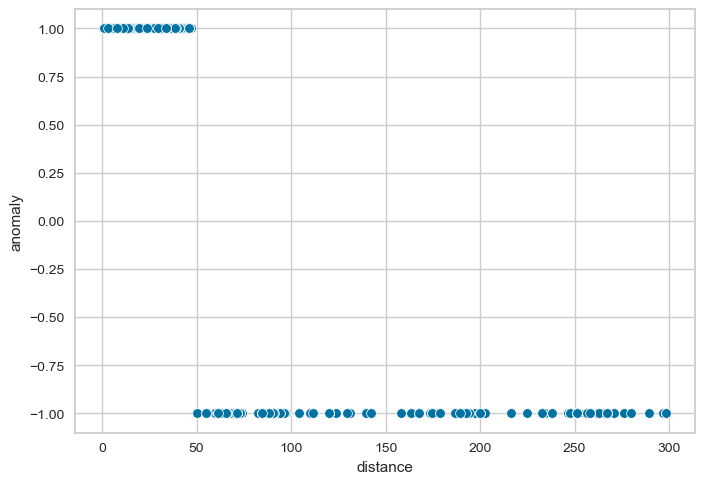

In [23]:
sns.scatterplot(test_df[test_df["distance"]<300], x="distance", y="anomaly")

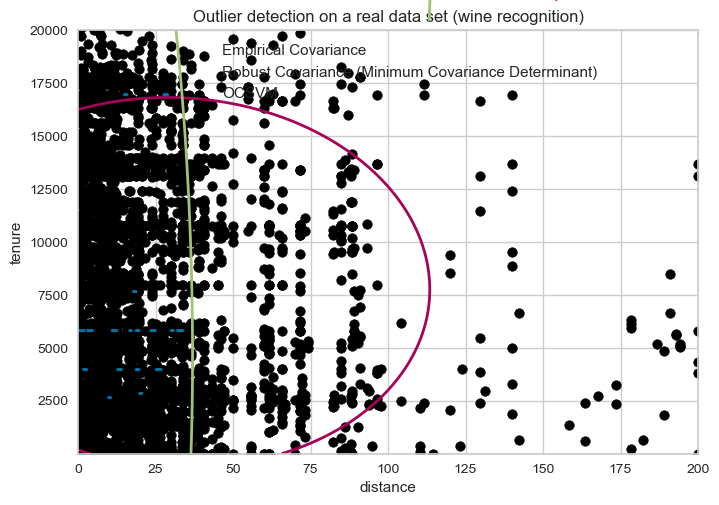

In [24]:
import numpy as np
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.datasets import load_wine

# Define "classifiers" to be used
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.0, contamination=0.25),
    "Robust Covariance (Minimum Covariance Determinant)": EllipticEnvelope(
        contamination=0.25
    ),
    "OCSVM": OneClassSVM(nu=0.25, gamma=0.35),
}
colors = ["m", "g", "b"]
legend1 = {}
legend2 = {}

# Get data
# X1 = load_wine()["data"][:, [1, 2]]  # two clusters
X1 = X_test_t[["distance", "spend_current"]]

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(0, 200, 500), np.linspace(1, 20000, 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1)
    clf.fit(X1)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i]
    )

legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

# Plot the results (= shape of the data points cloud)
plt.figure(1)  # two clusters
plt.title("Outlier detection on a real data set (wine recognition)")
# plt.scatter(X1[:, 0], X1[:, 1], color="black")
plt.scatter(X1["distance"], X1["spend_current"], color="black")
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend(
    (
        legend1_values_list[0].collections[0],
        legend1_values_list[1].collections[0],
        legend1_values_list[2].collections[0],
    ),
    (legend1_keys_list[0], legend1_keys_list[1], legend1_keys_list[2]),
    loc="upper center",
    prop=matplotlib.font_manager.FontProperties(size=11),
)
plt.xlabel("distance")
plt.ylabel("tenure")

plt.show()

# Gridsearch Isolation Forest + Estimator

In [25]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

In [58]:
class CustomTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, column_names= [], column_to_transform=None, bottom=1.5, top=1.5):
        # self.some_stuff = some_stuff
        self.column_names = column_names
        self.column_to_transform = column_to_transform
        self.bottom = bottom
        self.top = top
        # self.kwargs = kwargs
    
    def subset_by_iqr(self, df, column, whisker_bottom=1.5, whisker_top=1.5):
        # Calculate Q1, Q2 and IQR
        q1 = df[column].quantile(0.25)                 
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        # Apply filter with respect to IQR, including optional whiskers
        filter = (df[column] >= q1 - whisker_bottom*iqr) & (df[column] <= q3 + whisker_top*iqr)
        return df.loc[filter]    

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # do stuff on X, and return dataframe
        # of the same shape - this gets messy
        # if the preceding item is a numpy array
        # and not a dataframe
        try:
            if isinstance(X, np.ndarray):
                X = pd.DataFrame(X, columns=self.column_names)
            
            X = self.subset_by_iqr(X, self.column_to_transform, self.bottom, self.top)
            # encoder = IsolationForest(**self.kwargs).fit(X)
            # # X = encoder.transform([X])
            # X["anomaly"] = encoder.predict([X])
            # X = X[X["anomaly"]!=-1]
            # X = X.drop("anomaly", axis=1)
            # encoder = OneHotEncoder().fit(X)
            # X = encoder.transform(X)
            # X['str_len'] = X['my_str'].apply(lambda x: str(x)).str.len()
            # X['custom_func'] = X['val'].apply(lambda x: 1 if x > 0.5 else -1)
            return X
        except:
            return X

In [89]:
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    # ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    # ('Ordinal encoding', OrdinalEncoder()),
    # ('Label encoding', LabelEncoder())
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    # ('customer', CustomTransformer(column_names=categorical_features)),
])

outlier_list = [(f'outlier_{x}', CustomTransformer(column_to_transform=x)) for x in X_train_t.columns]

outlier_pipeline = Pipeline(steps=[
    ('test1', CustomTransformer('distance')),
    ('test2', CustomTransformer('tenure')),
    ('test3', CustomTransformer('spend_current')),
    # outlier_list
    # ('isolation-forest', CustomTransformer())
])

# ordinal_pipeline = Pipeline(steps=[
#     ('impute', SimpleImputer(strategy='most_frequent')),
#     ('ordinal', OrdinalEncoder(handle_unknown='ignore', spare=False))
# ])

[('outlier_atp_last', CustomTransformer(column_to_transform='atp_last')), ('outlier_attended_last', CustomTransformer(column_to_transform='attended_last')), ('outlier_distance', CustomTransformer(column_to_transform='distance')), ('outlier_events_last', CustomTransformer(column_to_transform='events_last')), ('outlier_spend_current', CustomTransformer(column_to_transform='spend_current')), ('outlier_sends', CustomTransformer(column_to_transform='sends')), ('outlier_tenure', CustomTransformer(column_to_transform='tenure')), ('outlier_opens', CustomTransformer(column_to_transform='opens')), ('outlier_volume_current', CustomTransformer(column_to_transform='volume_current'))]


In [90]:
outlier_list = ((f'outlier_{x}', outlier_pipeline, X_train_t.columns) for x in X_train_t.columns)
full_processor = ColumnTransformer(transformers=[
    # outlier_list
    ('outliers', outlier_pipeline, X_train_t.columns),
    # ('number', numeric_pipeline, numerical_features),
    # ('category', categorical_pipeline, categorical_features),
    # ('ordinal', ordinal_pipeline, ordinal_features)
])

In [91]:
rf_test = RandomForestClassifier()
rf_test.fit(X_train_t, y_train_t)
score = rf_test.score(X_test_t, y_test_t)
pred = rf_test.predict(X_test_t)
print_scores(pred, y_test_t)

MAE: 0.23832460732984292
F1: [0.94693609 0.63       0.36199095 0.80642284]
F1: 0.871590085536742
Accuracy: 0.8672251308900524
MCC: 0.7487023612969581


In [92]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

model = SVC(decision_function_shape='ovo')

# model = RandomForestClassifier()

model_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', model)
])

_ = model_pipeline.fit(X_train_t, y_train_t)
pred = model_pipeline.predict(X_test_t)
test_123 = full_processor.transform(X_train_t)
print_scores(y_test, pred)

MAE: 0.4469109947643979
F1: [0.88783519 0.         0.         0.71728127]
F1: 0.7246627833661525
Accuracy: 0.7763350785340314
MCC: 0.5792960237724459


In [95]:
model_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocess', 'model', 'preprocess__n_jobs', 'preprocess__remainder', 'preprocess__sparse_threshold', 'preprocess__transformer_weights', 'preprocess__transformers', 'preprocess__verbose', 'preprocess__outliers', 'preprocess__outliers__memory', 'preprocess__outliers__steps', 'preprocess__outliers__verbose', 'preprocess__outliers__test1', 'preprocess__outliers__test2', 'preprocess__outliers__test3', 'preprocess__outliers__test1__bottom', 'preprocess__outliers__test1__column_names', 'preprocess__outliers__test1__column_to_transform', 'preprocess__outliers__test1__top', 'preprocess__outliers__test2__bottom', 'preprocess__outliers__test2__column_names', 'preprocess__outliers__test2__column_to_transform', 'preprocess__outliers__test2__top', 'preprocess__outliers__test3__bottom', 'preprocess__outliers__test3__column_names', 'preprocess__outliers__test3__column_to_transform', 'preprocess__outliers__test3__top', 'model__C', 'model__break_ties', 'model__c

In [108]:
# clf = IsolationForest(random_state=47, behaviour='new')

param_grid = {
              'preprocess__outliers__test1__bottom': [0, 2.5], 
              'preprocess__outliers__test1__top': [0, 2.5],
              'preprocess__outliers__test2__bottom': [0, 2.5],
              'preprocess__outliers__test2__top': [0, 2.5],
              'preprocess__outliers__test3__bottom': [0, 2.5],
              'preprocess__outliers__test3__top': [0, 2.5],
              }

grid_dt_estimator = GridSearchCV(model_pipeline, 
                                param_grid,
                                scoring="accuracy", 
                                refit=True,
                                cv=10, 
                                return_train_score=True)
grid_search = grid_dt_estimator.fit(X_train_t, y_train_t)

In [110]:
print('Best score:', abs(grid_search.best_score_))
print('Best alpha:', grid_search.best_params_)

Best score: 0.7736772531579619
Best alpha: {'preprocess__outliers__test1__bottom': 0, 'preprocess__outliers__test1__top': 0, 'preprocess__outliers__test2__bottom': 0, 'preprocess__outliers__test2__top': 0, 'preprocess__outliers__test3__bottom': 0, 'preprocess__outliers__test3__top': 0}


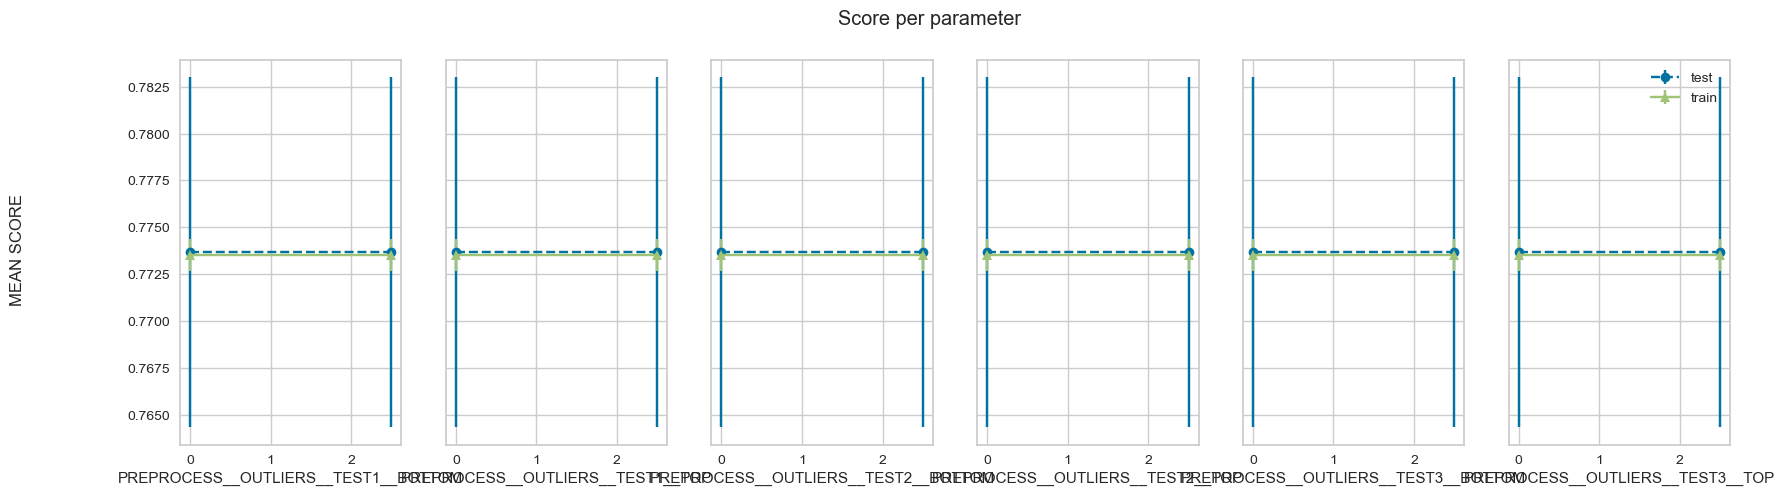

In [109]:
plot_search_results(grid_search)